In [12]:
!pip install numpy pandas statsmodels matplotlib


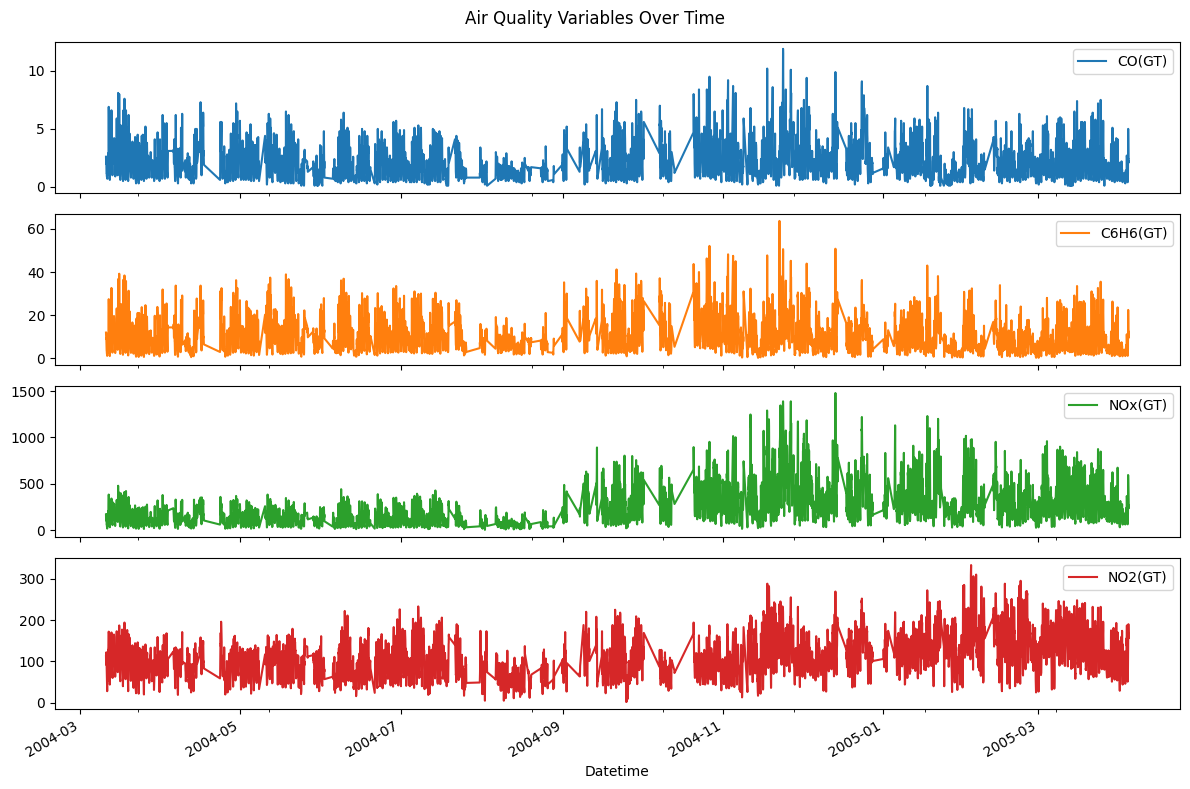

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


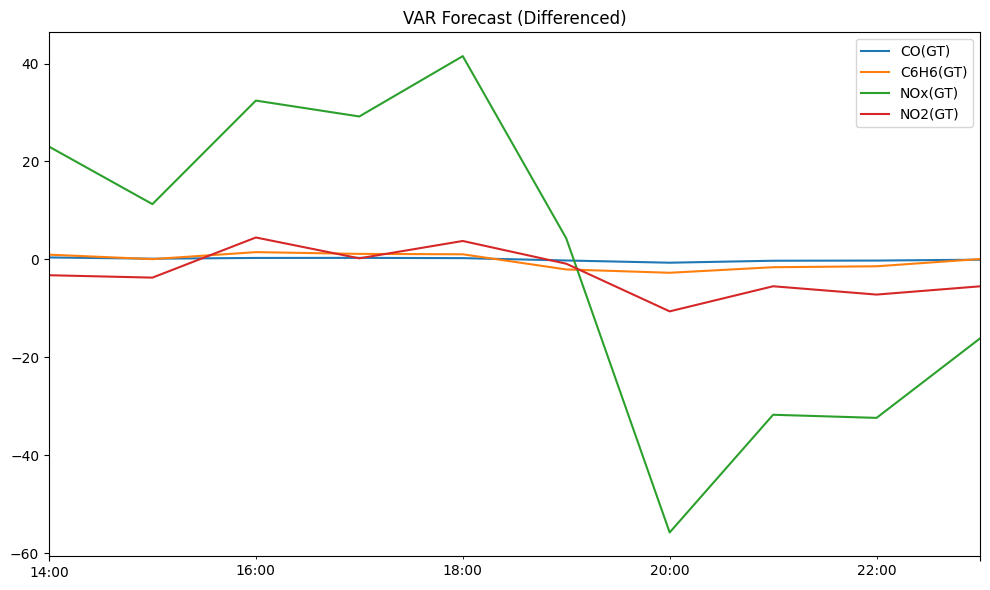

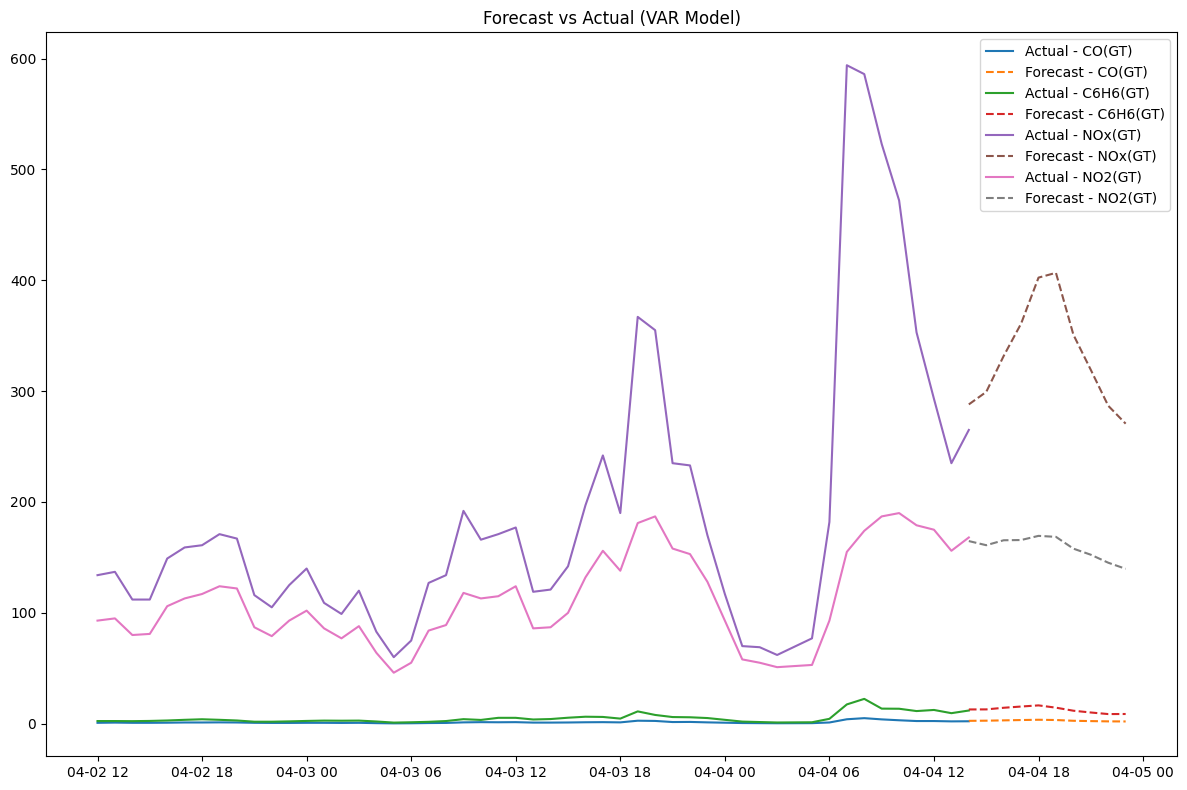

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# Step 1: Load and clean the dataset
df = pd.read_csv('/content/AirQuality.csv', sep=';', decimal=',', na_values=-200)

# Step 2: Combine 'Date' and 'Time' into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df.set_index('Datetime', inplace=True)

# Step 3: Drop unnecessary or NaN-dominant columns
df.drop(columns=['Date', 'Time', 'NMHC(GT)', 'Unnamed: 15', 'Unnamed: 16'], errors='ignore', inplace=True)

# Step 4: Convert all remaining data to numeric and drop rows with missing values
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)

# Step 5: Resample to hourly average (optional but good for noise reduction)
df = df.resample('h').mean()

# Step 6: Select key variables for VAR modeling
variables = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
df_selected = df[variables].dropna()

# Step 7: Plot the original time series
df_selected.plot(subplots=True, figsize=(12, 8), title='Air Quality Variables Over Time')
plt.tight_layout()
plt.show()

# Step 8: First differencing to make the data stationary
df_diff = df_selected.diff().dropna()

# Step 9: Fit the VAR model using AIC-selected lag
model = VAR(df_diff)
results = model.fit(maxlags=15, ic='aic')

# Step 10: Forecast next 10 steps
forecast_input = df_diff.values[-results.k_ar:]
forecast = results.forecast(y=forecast_input, steps=10)

# Step 11: Create forecast DataFrame
forecast_df = pd.DataFrame(forecast, columns=df_diff.columns)
forecast_df.index = pd.date_range(start=df_diff.index[-1], periods=10, freq='h')

# Step 12: Plot differenced forecast
forecast_df.plot(figsize=(10, 6), title='VAR Forecast (Differenced)')
plt.tight_layout()
plt.show()

# Step 13: Convert differenced forecast back to original scale
last_actual = df_selected.iloc[-1]
forecast_original = forecast_df.cumsum() + last_actual

# Step 14: Plot actual vs forecast (original scale)
plt.figure(figsize=(12, 8))
for col in forecast_original.columns:
    plt.plot(df_selected[col].iloc[-50:], label=f'Actual - {col}')
    plt.plot(forecast_original[col], linestyle='--', label=f'Forecast - {col}')
plt.legend()
plt.title("Forecast vs Actual (VAR Model)")
plt.tight_layout()
plt.show()
